# Explorer static devices data

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numexpr
%matplotlib inline
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = [8, 6]

In [14]:
loravar = pd.read_csv('../data/lora_mons_static.csv')
devices = pd.read_csv('../data/devices.csv')
loravar = loravar.merge(devices, on='dev_id')
loravar['received'] = pd.to_datetime(loravar['received'])
loravar['start_timestamp'] = pd.to_datetime(loravar['start_timestamp'])
loravar = loravar.loc[loravar['received'] > loravar['start_timestamp']]
#loravar.drop(columns=['dev_eui', 'counter', 'coding_rate', 'start_timestamp'], inplace=True)
loravar.dropna(inplace=True)

## Data repartition

Once unclean data are removed, here is the count of packets sent from a device identified by `dev_id` and received by a gateway identified by `gtw_id`.
The `iotlab-rpi-03` gateway only received packets from 3 devices.
The count of received packets varies a lot from a device to another.

In [15]:
loravar.pivot_table(index=['dev_id'], columns=['gtw_id'], aggfunc='size', fill_value=0)

gtw_id,eui-0000024b08030186,iotlab-rpi-03
dev_id,,
static_6_01,2197,0
static_6_02,3053,0
static_6_03,5659,3483
static_7_01,5555,4551
static_7_02,5557,77
static_8_01,4219,0
static_8_03,2623,1723
static_8_04,20,0


The boxplots of both the RSSI and the SNR on the most present gateway shows a big difference between devices.

In [16]:
loravar.set_index('received', inplace=True)
loravar.index.tz_convert('Europe/Brussels')
loravar['hour'] = loravar.index.hour
loravar['weekday'] = loravar.index.weekday
houzeau_gtw = loravar.query('gtw_id == "eui-0000024b08030186"')

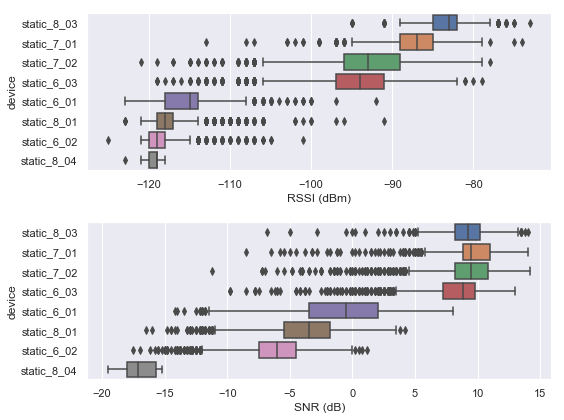

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1)
sns.boxplot(x='rssi', y='dev_id', data=houzeau_gtw, ax=ax1,
            order=['static_8_03', 'static_7_01', 'static_7_02', 'static_6_03', 
                   'static_6_01', 'static_8_01', 'static_6_02', 'static_8_04'])
ax1.set_ylabel('device')
ax1.set_xlabel('RSSI (dBm)')
sns.boxplot(x='snr', y='dev_id', data=houzeau_gtw, ax=ax2,
            order=['static_8_03', 'static_7_01', 'static_7_02', 'static_6_03', 
                   'static_6_01', 'static_8_01', 'static_6_02', 'static_8_04'])
ax2.set_ylabel('device')
ax2.set_xlabel('SNR (dB)')
plt.tight_layout()
fig.savefig('../rssi_snr_distribution.png')

## Temporal evolution

The following graphs use data downsampled into 3-hour bins using the mean of the values.
The RSSI and SNR evolution over time are very different between devices.

Device `static_6_01` only started to send valid packets at the end of the analyzed period.

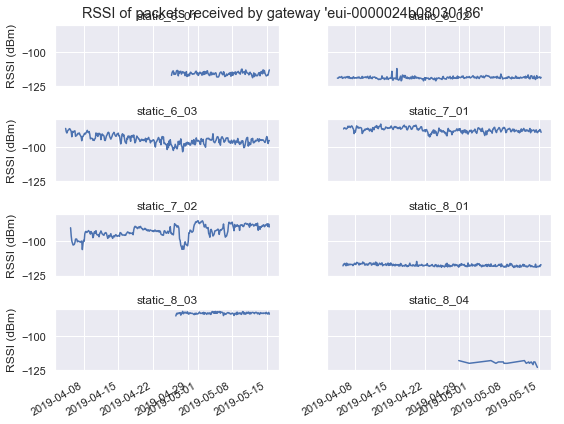

In [33]:
fig, axes = plt.subplots(4, 2, sharey=True, sharex=True)
fig.suptitle("RSSI of packets received by gateway 'eui-0000024b08030186'")
fig.autofmt_xdate()

dev_ids = np.sort(houzeau_gtw['dev_id'].unique())
for ax, dev_id in zip(axes.flatten(), dev_ids):
    dev_pkts = houzeau_gtw.query("dev_id == '{0}'".format(dev_id)).resample('3H').mean()
    sns.lineplot(x=dev_pkts.index, y=dev_pkts['rssi'], ax=ax)
    ax.set_title(dev_id)
    ax.set_xlabel('')
    ax.set_ylabel('RSSI (dBm)')
plt.tight_layout()

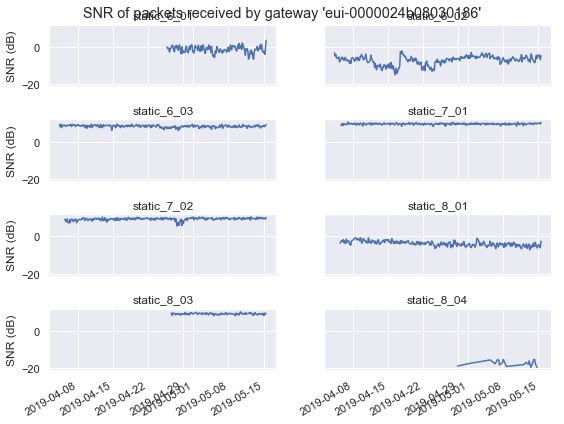

In [34]:
fig, axes = plt.subplots(4, 2, sharey=True, sharex=True)
fig.suptitle("SNR of packets received by gateway 'eui-0000024b08030186'")
fig.autofmt_xdate()

for ax, dev_id in zip(axes.flatten(), dev_ids):
    dev_pkts = houzeau_gtw.query("dev_id == '{0}'".format(dev_id)).resample('3H').mean()
    sns.lineplot(x=dev_pkts.index, y=dev_pkts['snr'], ax=ax)
    ax.set_title(dev_id)
    ax.set_xlabel('')
    ax.set_ylabel('SNR (dB)')
plt.tight_layout()

### By hour


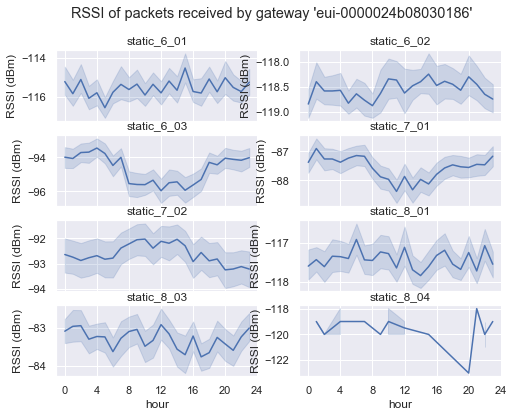

In [35]:
fig, axes = plt.subplots(4, 2, sharex=True)
fig.suptitle("RSSI of packets received by gateway 'eui-0000024b08030186'")

for ax, dev_id in zip(axes.flatten(), dev_ids):
    dev_pkts = houzeau_gtw.query("dev_id == '{0}'".format(dev_id))
    sns.lineplot(x='hour', y='rssi', data=dev_pkts, ax=ax)
    ax.set_title(dev_id)
    ax.set_xlabel('hour')
    ax.set_ylabel('RSSI (dBm)')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))

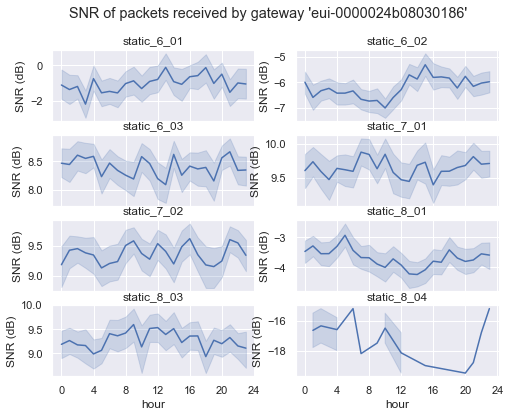

In [36]:
fig, axes = plt.subplots(4, 2, sharex=True)
fig.suptitle("SNR of packets received by gateway 'eui-0000024b08030186'")

for ax, dev_id in zip(axes.flatten(), dev_ids):
    dev_pkts = houzeau_gtw.query("dev_id == '{0}'".format(dev_id))
    sns.lineplot(x='hour', y='snr', data=dev_pkts, ax=ax)
    ax.set_title(dev_id)
    ax.set_xlabel('hour')
    ax.set_ylabel('SNR (dB)')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))


### By day of week


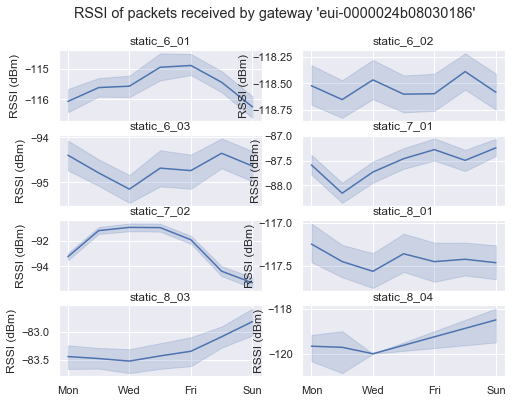

In [37]:
fig, axes = plt.subplots(4, 2, sharex=True)
fig.suptitle("RSSI of packets received by gateway 'eui-0000024b08030186'")

for ax, dev_id in zip(axes.flatten(), dev_ids):
    dev_pkts = houzeau_gtw.query("dev_id == '{0}'".format(dev_id))
    sns.lineplot(x='weekday', y='rssi', data=dev_pkts, ax=ax)
    ax.set_title(dev_id)
    ax.set_xlabel('')
    ax.set_ylabel('RSSI (dBm)')
    ax.xaxis.set_major_formatter(ticker.IndexFormatter(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))

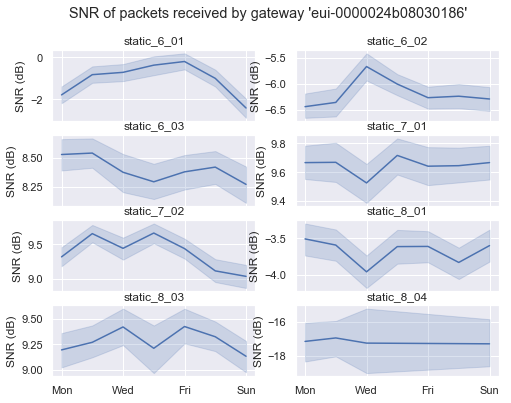

In [38]:
fig, axes = plt.subplots(4, 2, sharex=True)
fig.suptitle("SNR of packets received by gateway 'eui-0000024b08030186'")

for ax, dev_id in zip(axes.flatten(), dev_ids):
    dev_pkts = houzeau_gtw.query("dev_id == '{0}'".format(dev_id))
    sns.lineplot(x='weekday', y='snr', data=dev_pkts, ax=ax)
    ax.set_title(dev_id)
    ax.set_xlabel('')
    ax.set_ylabel('SNR (dB)')
    ax.xaxis.set_major_formatter(ticker.IndexFormatter(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))
